In [3]:
import numpy as np
#from osgeo import gdal, gdal_array
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import pathlib
import platform 
import json 
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
import matplotlib as mpl
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import imageio.v2 as imageio
import xarray as xr
from rasterio import features
from rasterio.plot import show

In [4]:
import sys
print(sys.executable)


/Users/matskerver/anaconda3/bin/python


In [5]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()
print(data)
if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'TAHMO', 'location_tahmo')
    data_path_location = os.path.join(data, 'data_tana')
    data_path_netcdf = os.path.join(data_path_location, 'TAHMO', 'interpolated')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO')
    data_path_location = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data')

print(f"Welcome {username}, have a wonderful day on your {OS_type} machine. Your data should be located in {data_path}")

/Users/matskerver/Documents
Welcome Mats , have a wonderful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/TAHMO/location_tahmo


<xarray.Dataset>
Dimensions:   (time: 2191, variable: 8)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-12-31
  * variable  (variable) object 'pr' 'te_mean' ... 'longitude' 'latitude'
Data variables: (12/31)
    TA00360   (time, variable) float64 ...
    TA00023   (time, variable) float64 ...
    TA00453   (time, variable) float64 ...
    TA00024   (time, variable) float64 ...
    TA00156   (time, variable) float64 ...
    TA00133   (time, variable) float64 ...
    ...        ...
    TA00067   (time, variable) float64 ...
    TA00754   (time, variable) float64 ...
    TA00108   (time, variable) float64 ...
    TA00189   (time, variable) float64 ...
    TA00074   (time, variable) float64 ...
    TA00416   (time, variable) float64 ...


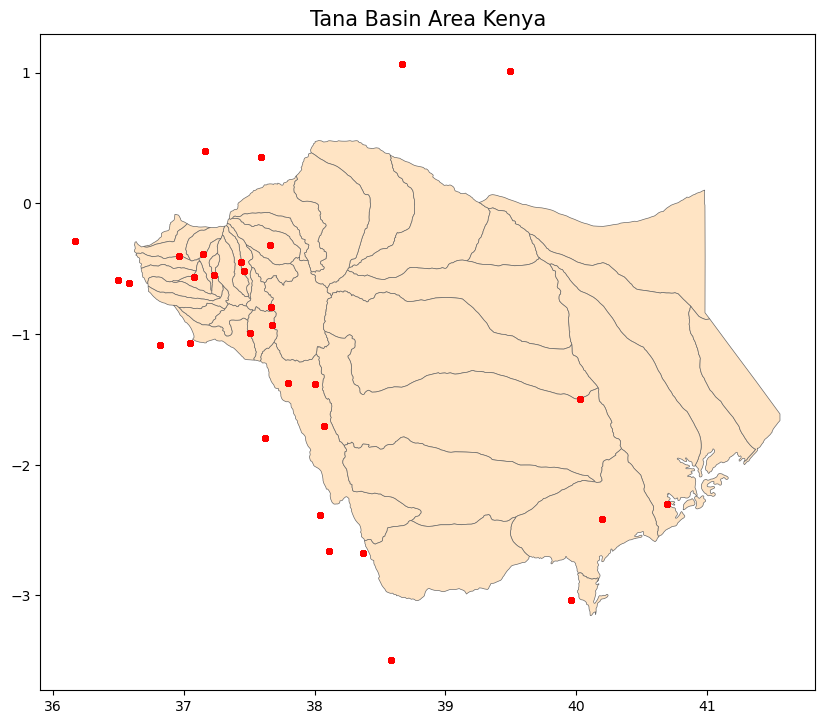

In [3]:
netcdf_file = 'NetCDF_TAHMO.nc'
#netcdf_file = 'weather_data_TAHMO.nc'
ds = xr.open_dataset(os.path.join(data_path, netcdf_file))

# Load geographical data
proj = 'EPSG:32737'
counties = gpd.read_file(os.path.join(data_path, 'total_tana_catchement_area_clip_projected.gpkg'))

# Variables for plotting
variable = 'te_mean'

geo_dataframes = {}
for station in ds.data_vars:
    # Extract longitude and latitude for each station
    # Assume longitude and latitude are constant over time; thus, we take the mean
    longitude = ds[station].sel(variable='longitude').mean().values.item()
    latitude = ds[station].sel(variable='latitude').mean().values.item()

    # Select the data for the variable of interest
    df = ds[station].sel(variable=variable).to_dataframe().reset_index()

    # Create a Point object for each station
    point = Point(longitude, latitude)

    # Create GeoDataFrame
    rain_gdf = gpd.GeoDataFrame(df, geometry=[point] * len(df), crs=proj)
    geo_dataframes[station] = rain_gdf

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.style.use('bmh')

counties.plot(ax=ax, color='bisque', edgecolor='dimgray')

for key, gdf in geo_dataframes.items():
    gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_title('Tana Basin Area Kenya', fontdict={'fontsize': '15', 'fontweight': '3'})

#plt.show()
print(ds)

In [4]:
#Warning! creates a file of multiple gb (about 6.5Gb for grid_space = 0.01)
netCDF_file = True 

if (netCDF_file == True):
    
    #Reads in the required datasets and shapefiles to use the Kriging interpolation on.
    ds = xr.open_dataset(os.path.join(data_path, 'NetCDF_TAHMO.nc'))
    path_shape = os.path.join(data_path, 'total_tana_catchement_area_clip.shp')
    shapefile = gpd.read_file(path_shape)
    
    #Variables that determine the grid resolution (in degrees longitude and latitude) and the extend of the earth 
    #to be plotted (same units).
    grid_space = 0.05
    variable = 'evap'
    longitudes_mapped = [36, 42]
    latitudes_mapped = [-4, 2]
    
    grid_lons = np.arange(longitudes_mapped[0], longitudes_mapped[1], grid_space)
    grid_lats = np.arange(latitudes_mapped[0], latitudes_mapped[1], grid_space)

    #Extract the station, location and variable data from the dataset ds
    latitudes = ds.sel(variable='latitude').to_array().mean(dim='time').values
    longitudes = ds.sel(variable='longitude').to_array().mean(dim='time').values
    station_ids = ds.sel(variable='latitude').to_array().mean(dim='time').coords['variable'].values
    variable_data = ds.sel(variable=variable)

    # Create empty variable to store the grids in and a variable to keep track of the progress of the interpolation.
    # Variable interval determines the timesteps on which the progess will be printed.
    z_values = []
    progress = 0
    interval = 25
    
    
    # ------------- Don't Change anything beneath this line. Variables should be changed above -------------- #

    
    #We loop through each of the timesteps in the provided netcdf file.
    for time_value in ds.time:
        
        #Empty array is created to store the current data variable to be interpolated on the grid
        data = []
        for station in ds.data_vars:
            # Select the data for the current time and variable of interest
            value = ds[station].sel(time=time_value, variable=variable).values
            data.append(value.item() if value.size > 0 else np.nan)
        
        # Convert the data to a numpy array so we can apply a mask. As some stations have gaps in their data we 
        # need to exclude these to prevent errors. This is done with the Mask. We also need to remove the longitudes
        # and latitudes of these points to ensure consistent array dimensions. 
        
        data = np.array(data)
        valid_mask = ~np.isnan(data)
        filtered_data = data[valid_mask]
        filtered_longitudes = longitudes[valid_mask]
        filtered_latitudes = latitudes[valid_mask]

        # Setup the Ordinary Kriging interpolator and subsequently execute it. It is then added to the array.
        OK = OrdinaryKriging(
            filtered_longitudes,
            filtered_latitudes,
            filtered_data,
            variogram_model='gaussian',
            verbose=False,
            enable_plotting=False
        )
        z, ss = OK.execute('grid', grid_lons, grid_lats)
        z_values.append(z)
        
        # Keep the user updated on the progress of the interpolation process as it can take some time.
        if (progress % interval == 0):
            print(progress)
        progress += 1

        
    # Put all the data back into a suitable Xarray to be converted into the final NetCDF file
    z_array = np.stack(z_values)

    time_dim = ds.time 
    lon_dim = np.arange(longitudes_mapped[0], longitudes_mapped[1], grid_space)  # Longitude grid
    lat_dim = np.arange(latitudes_mapped[0], latitudes_mapped[1], grid_space)  # Latitude grid
    kriging_ds = xr.Dataset(
        {
            variable: (['time', 'latitude', 'longitude'], z_array)
        },
        coords={
            'time': time_dim,
            'latitude': lat_dim,
            'longitude': lon_dim
        }
    )

    kriging_ds.to_netcdf(os.path.join(data_path_netcdf, 'kriging_results_evap.nc'))

#ds = xr.open_dataset(os.path.join(data_path_netcdf, netcdf_file_raster))

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975
2000
2025
2050
2075
2100
2125
2150
2175


In [5]:
data = []
variable = 'te_mean'

for station in ds.data_vars:
    # Select the data for the current time and variable of interest
    value = ds[station].sel(time=167, variable=variable).values
    data.append(value.item() if value.size > 0 else np.nan)
    
print(data)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [ ]:
'''cdict = {
        'red':   [(0.0, 1.0, 1.0), (0.05, 0.59, 0.59), (1.0, 0.0, 0.0)],
        'green': [(0.0, 1.0, 1.0), (0.05, 0.29, 0.29), (0.2, 1.0, 1.0), (1.0, 0.0, 0.0)],
        'blue':  [(0.0, 0.88, 0.88), (0.05, 0.1, 0.1), (0.2, 1.0, 1.0), (1.0, 1.0, 1.0)]
    }

cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

# Load the dataset
netcdf_file_raster = 'kriging_results.nc'
ds = xr.open_dataset(os.path.join(data_path_netcdf, netcdf_file_raster))

# Define the variable and time range
variable = 'z'
time_indices = range(0, ds.dims['time'], 1)  # Adjust the step based on your needs

# Shapefile path
path_shape = os.path.join(data_path, 'total_tana_catchement_area_clip.shp')
shapefile_gdf = gpd.read_file(path_shape)

# List to store image file paths
file_paths = []

for time_index in time_indices:
    selected_data = ds.isel(time=time_index)
    data_array = selected_data[variable]

    # Generate raster
    grid_lons, grid_lats = ds['longitude'].values, ds['latitude'].values
    grid_space = grid_lons[1] - grid_lons[0]
    transform = rasterio.transform.from_origin(min(grid_lons), max(grid_lats), grid_space, grid_space)
    temp_tif = 'temp.tif'
    with rasterio.open(
        temp_tif, 'w', driver='GTiff',
        height=data_array.shape[0], width=data_array.shape[1],
        count=1, dtype=str(data_array.dtype),
        crs='+proj=latlong',
        transform=transform
    ) as raster:
        raster.write(data_array.values, 1)

    # Clip raster
    with rasterio.open(temp_tif) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapefile_gdf.geometry, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    clipped_tif = 'clipped.tif'
    with rasterio.open(clipped_tif, 'w', **out_meta) as dest:
        dest.write(out_image)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    with rasterio.open(clipped_tif) as raster_plot:
        img_array = raster_plot.read(1)
        extent = [out_transform[2], out_transform[2] + out_transform[0] * img_array.shape[1],
                  out_transform[5] + out_transform[4] * img_array.shape[0], out_transform[5]]

        img = ax.imshow(img_array, extent=extent, cmap=cm, origin='upper', vmin=15, vmax=30)  # Use your custom colormap
        ax.set_title(f'{variable} on {selected_data.time.dt.strftime("%Y-%m-%d").values}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(variable)

    # Save the plot
    image_filename = f'image_{time_index}.png'
    plt.savefig(image_filename)
    plt.close()

    file_paths.append(image_filename)

# Create GIF
gif_filename = f'time_series_{variable}.gif'  # Construct the file name safely
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in file_paths:
        image = imageio.imread(filename)
        writer.append_data(image)

    # Optionally, delete the individual image files after creating the GIF
    for filename in file_paths:
        os.remove(filename)'''